In [141]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import boto3
import sagemaker
from sagemaker import get_execution_role
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
#getting bucket name
s3 = boto3.client('s3')
bucket = s3.list_buckets()
bucket_names = [bucket['Name'] for bucket in bucket['Buckets']]

for bucket_name in bucket_names:
    bucket_url = bucket_name
    print(f"Bucket name: {bucket_name}")

In [ ]:
# AWS credentials
aws_access_key = 'xxx'
aws_secret_access_key = 'xxx'
aws_region = 'us-east-2'

# Create a SageMaker Session
sess = sagemaker.Session()
# Get the SageMaker execution role
role = get_execution_role()
# S3 bucket and file information
bucket_name = 'xxx'

# Create an S3 client
s3 = boto3.client('s3', aws_access_key_id=aws_access_key, aws_secret_access_key=aws_secret_access_key, region_name=aws_region)
  

In [70]:
df_blazingtext = pd.read_csv('df_clean_labeled_tokenized.csv')

In [71]:
df_blazingtext

,sentiment,tokenized_review
0,-1,"['Carmencita', 'short', 'video', 'woman', 'dan..."
1,-1,"['Like', 'work', 'Autour', 'dune', 'cabine', '..."
2,1,"['1891', 'Thomas', 'Edison', 'staff', 'led', '..."
3,1,"['James', 'J', 'Corbett', 'better', 'known', '..."
4,0,"['film', 'Fred', 'Ott', 'employee', 'Thomas', ..."
...,...,...
32500,1,"['watched', 'Trial', 'Catonsville', 'Nine', 'f..."
32501,1,"['TRILOGY', 'SWORDSMANSHIP', 'came', 'bit', 's..."
32502,-1,"['Trinity', 'Sartana', 'originally', 'released..."
32503,0,"['also', 'find', 'first', 'review', 'film', 'S..."


In [72]:
#Changing the label type for the need of BlazingText fit function
def prepare_data(df):
    df = df.map(lambda sentiment : '__label__{}'.format(str(sentiment).replace('__label__', '')))
    return df



df_blazingtext['sentiment'] = prepare_data(df_blazingtext['sentiment'])
df_blazingtext.head()

,sentiment,tokenized_review
0,__label__-1,"['Carmencita', 'short', 'video', 'woman', 'dan..."
1,__label__-1,"['Like', 'work', 'Autour', 'dune', 'cabine', '..."
2,__label__1,"['1891', 'Thomas', 'Edison', 'staff', 'led', '..."
3,__label__1,"['James', 'J', 'Corbett', 'better', 'known', '..."
4,__label__0,"['film', 'Fred', 'Ott', 'employee', 'Thomas', ..."


In [73]:
df_blazingtext

,sentiment,tokenized_review
0,__label__-1,"['Carmencita', 'short', 'video', 'woman', 'dan..."
1,__label__-1,"['Like', 'work', 'Autour', 'dune', 'cabine', '..."
2,__label__1,"['1891', 'Thomas', 'Edison', 'staff', 'led', '..."
3,__label__1,"['James', 'J', 'Corbett', 'better', 'known', '..."
4,__label__0,"['film', 'Fred', 'Ott', 'employee', 'Thomas', ..."
...,...,...
32500,__label__1,"['watched', 'Trial', 'Catonsville', 'Nine', 'f..."
32501,__label__1,"['TRILOGY', 'SWORDSMANSHIP', 'came', 'bit', 's..."
32502,__label__-1,"['Trinity', 'Sartana', 'originally', 'released..."
32503,__label__0,"['also', 'find', 'first', 'review', 'film', 'S..."


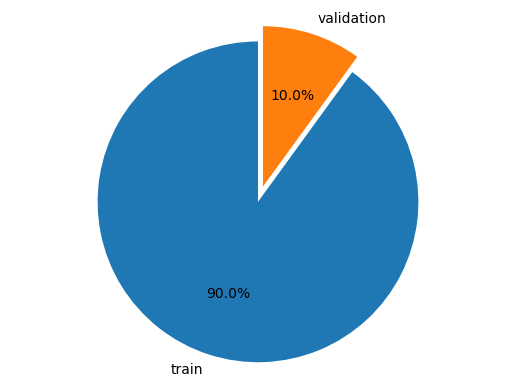

Train set size is: 29254
Validation set size is: 3251


In [125]:

# Split all data into 90% train and 10% holdout
df_train, df_validation = train_test_split(df_blazingtext, 
                                           test_size=0.10,
                                           stratify=df_blazingtext['sentiment'])

labels = ['train', 'validation']
sizes = [len(df_train.index), len(df_validation.index)]
explode = (0.1, 0)  

fig1, ax1 = plt.subplots()

ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax1.axis('equal')  

plt.show()
print(f'Train set size is: {len(df_train)}' )
print(f'Validation set size is: {len(df_validation)}' )

In [126]:
#Save result as CSV
blazingtext_train_path = './train.csv'
df_train[['sentiment', 'tokenized_review']].to_csv(blazingtext_train_path, index=False, header=False, sep=' ')

In [127]:
blazingtext_validation_path = './validation.csv'
df_validation[['sentiment', 'tokenized_review']].to_csv(blazingtext_validation_path, index=False, header=False, sep=' ')

In [128]:
#Upload train and validation set for blazingtext to s3
train_s3_uri = sess.upload_data(bucket=bucket_url, key_prefix='blazingtext/data', path=blazingtext_train_path)
validation_s3_uri = sess.upload_data(bucket=bucket_url, key_prefix='blazingtext/data', path=blazingtext_validation_path)
print("Train and Validation sets uploaded to S3")

Train and Validation sets uploaded to S3


#### Train the BlazingText model

In [132]:
image_uri = sagemaker.image_uris.retrieve(
    region=aws_region,
    framework='blazingtext'
)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [130]:
estimator = sagemaker.estimator.Estimator(
    image_uri=image_uri,
    role=role, 
    instance_count=1, 
    instance_type='ml.m5.large',
    volume_size=30,
    max_run=7200,
    sagemaker_session=sess
)

In [133]:
estimator.set_hyperparameters(mode='supervised',   # supervised (text classification)
                              epochs=15,           # number of complete passes through the dataset: 5 - 15
                              learning_rate=0.001,  # step size for the  numerical optimizer: 0.005 - 0.01
                              min_count=2,         # discard words that appear less than this number: 0 - 100                              
                              vector_dim=300,      # number of dimensions in vector space: 32-300
                              word_ngrams=3)       # number of words in a word n-gram: 1 - 3

In [134]:
train_data = sagemaker.inputs.TrainingInput(
    train_s3_uri,
    distribution='FullyReplicated', 
    content_type='text/plain', 
    s3_data_type='S3Prefix'
)

In [135]:
validation_data = sagemaker.inputs.TrainingInput(
    validation_s3_uri,
    distribution='FullyReplicated', 
    content_type='text/plain', 
    s3_data_type='S3Prefix'
)

In [136]:
data_channels = {
    'train': train_data, 
    'validation': validation_data 
}

In [137]:
estimator.fit(
    inputs=data_channels,
    wait=False
)

training_job_name = estimator.latest_training_job.name
print('Training Job Name:  {}'.format(training_job_name))

INFO:sagemaker:Creating training-job with name: blazingtext-2023-12-20-22-15-41-519


Training Job Name:  blazingtext-2023-12-20-22-15-41-519


In [138]:
%%time

estimator.latest_training_job.wait(logs=False)


2023-12-20 22:15:42 Starting - Starting the training job.
2023-12-20 22:15:55 Starting - Preparing the instances for training............
2023-12-20 22:17:02 Downloading - Downloading input data........
2023-12-20 22:17:48 Downloading - Downloading the training image..
2023-12-20 22:18:03 Training - Training image download completed. Training in progress..................
2023-12-20 22:19:34 Uploading - Uploading generated training model.....................
2023-12-20 22:21:25 Completed - Training job completed
CPU times: user 294 ms, sys: 40.8 ms, total: 335 ms
Wall time: 5min 43s


In [139]:
estimator.training_job_analytics.dataframe()

,timestamp,metric_name,value
0,0.0,train:accuracy,0.4739
1,0.0,validation:accuracy,0.4752


In [140]:
%%time

text_classifier = estimator.deploy(initial_instance_count=1,
                                   instance_type='ml.m5.large',
                                   serializer=sagemaker.serializers.JSONSerializer(),
                                   deserializer=sagemaker.deserializers.JSONDeserializer())

print()
print('Endpoint name:  {}'.format(text_classifier.endpoint_name))

INFO:sagemaker:Creating model with name: blazingtext-2023-12-20-22-25-27-217
INFO:sagemaker:Creating endpoint-config with name blazingtext-2023-12-20-22-25-27-217
INFO:sagemaker:Creating endpoint with name blazingtext-2023-12-20-22-25-27-217


-----!
Endpoint name:  blazingtext-2023-12-20-22-25-27-217
CPU times: user 68.5 ms, sys: 11.5 ms, total: 80 ms
Wall time: 3min 2s


In [145]:
df_validation

,sentiment,tokenized_review
23905,__label__0,"['admit', 'review', 'based', '36', 'minute', '..."
14533,__label__1,"['TENNIS', 'CHUMPS', 'one', 'glaring', 'anomal..."
32294,__label__1,"['Lucio', 'Fulci', 'made', 'good', 'movie', 'k..."
7369,__label__-1,"['early', 'days', 'Looney', 'Tunes', 'cartoons..."
683,__label__1,"['movie', 'beautiful', 'love', 'box', 'tissues..."
...,...,...
9189,__label__0,"['One', 'many', 'Universal', 'programmers', 's..."
19629,__label__0,"['scenario', 'rather', 'banal', 'bought', 'spl..."
18048,__label__1,"['young', 'remember', 'much', 'Kate', 'Smith',..."
22886,__label__1,"['enjoying', 'movies', 'different', 'era', 'ho..."


In [146]:
reviews = df_validation['tokenized_review']

tokenized_reviews = [' '.join(nltk.word_tokenize(review)) for review in reviews]

payload = {"instances" : tokenized_reviews}
print(payload)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [167]:
predictions = text_classifier.predict(data=payload)
pred_label = []

for prediction in predictions:
    pred_label.append(prediction['label'])  # Assuming the predicted label is stored in the 'label' key
print('Done')


pd.DataFrame({'Predicted Label': pred_label, 'True Label': df_validation['sentiment']})

Done


,Predicted Label,True Label
23905,[__label__1],__label__0
14533,[__label__1],__label__1
32294,[__label__0],__label__1
7369,[__label__1],__label__-1
683,[__label__1],__label__1
...,...,...
9189,[__label__1],__label__0
19629,[__label__0],__label__0
18048,[__label__1],__label__1
22886,[__label__1],__label__1
